### Making Predictions with the Keras Model
Next we will run predictions with our Tensorflow model & view some random results.

# Loading model

In [1]:
%run commonCode

Using TensorFlow backend.


Loaded the images of dataset-Ellipse

Loaded the images of dataset-Quadrilateral

Loaded the images of dataset-Triangle



In [2]:
import tensorflow as tf

# load model
kr_model = tf.compat.v1.keras.models.load_model(KR_MODEL_NAME)
# summarize model.
kr_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 40, 40, 64)        5248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 64)        331840    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dropout (Dropout)            (None, 6400)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 1

In [3]:
predictions = kr_model.predict(X_test)
# reverse one-hot encode the predictions
y_pred = np.argmax(predictions, axis=1)
# reverse one-hot encode of test data (this is the ground truth)
y_true = np.argmax(y_test, axis=1)
#y_pred[:30]
# count of predictions & how many incorrect predictions overall??
len(y_pred), (y_pred != y_true).sum()

(2400, 130)

Displaying a sample of 50 mistaken images from dataset


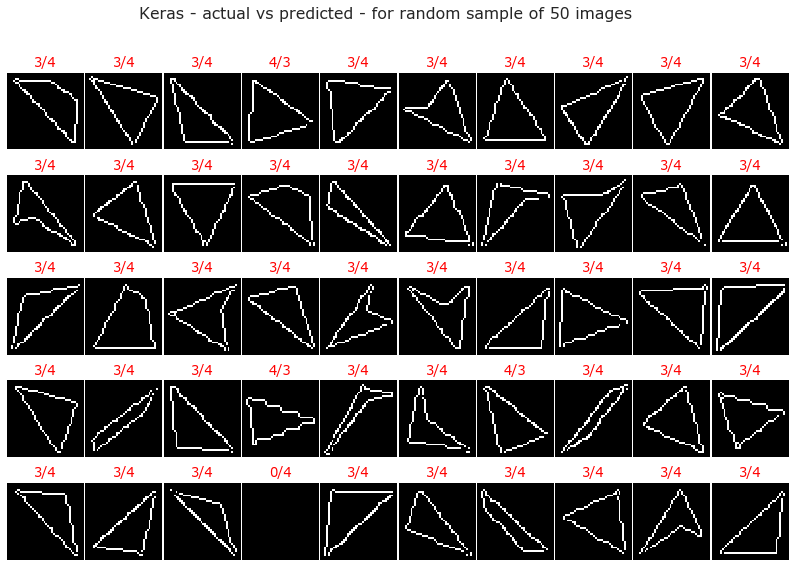

In [4]:
# NOTE: the title of each cell shows the predicted value in green if prediction matches actual
# else cell title shows actual/predicted value in red font
sample_size = 50
print('Displaying a sample of {} mistaken images from dataset'.format(sample_size))
indexes = np.where(y_pred != y_true)[0].astype('int32')[:sample_size]
sample_images, sample_labels, sample_predictions = test_images[indexes], test_labels[indexes], y_pred[indexes]
display_sample(sample_images, sample_labels, sample_predictions=sample_predictions, 
               num_rows=5, num_cols=10, 
               plot_title="Keras - actual vs predicted - for random sample of {} images".format(sample_size))

# User Interface

In [8]:
import tkinter
from tkinter import filedialog
from tkinter import *
from PIL import ImageTk, Image

window = tkinter.Tk()
window.geometry('200x200')
window.configure(background = 'PeachPuff3')

def predict_img():
    img_data_list=[]
    input_img=cv2.imread(window.filename,0)
    input_img_resize=cv2.resize(input_img,(IMAGE_HEIGHT,IMAGE_WIDTH))
    img_data_list.append(input_img_resize)
    X_input = np.array(img_data_list)
    num_data = X_input.shape[0]
    X_input = X_input.astype('float32') / 255.0
    X_input = np.reshape(X_input, (X_input.shape[0], X_input.shape[1], X_input.shape[2], num_channels))
    predictions = kr_model.predict(X_input)
    y_pred = np.argmax(predictions, axis=1)
    lbl.config(text = class_names[y_pred[0]])
    
def ask_for_file():
    window.filename =  filedialog.askopenfilename(initialdir = "/",title = "Select file",
                                            filetypes = (("jpeg files","*.jpg;*.png"),("all files","*.*")))
    if window.filename != '':
        img = ImageTk.PhotoImage(Image.open(window.filename))
        panel = Label(window, image = img)
        panel.pack(side = "bottom")#, fill = "both", expand = "yes")
        predict_img()
        window.mainloop()

btn = tkinter.Button(window, text = 'Add Test Image', command = ask_for_file)
btn.pack()


lbl = tkinter.Label(window, text = 'Nothing yet!')
lbl.pack(fill=X)

def predict_image():
    input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img,0)
window.mainloop()

In [9]:
kr_model.summary()
#kr_model.layers[0].get_weights()
# summarize filter shapes
for layer in kr_model.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 40, 40, 64)        5248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 64)        331840    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dropout (Dropout)            (None, 6400)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 1

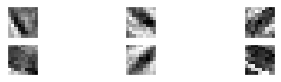

In [10]:
import matplotlib.pyplot as pyplot
model = kr_model
# retrieve weights from the second hidden layer
filters, biases = model.layers[0].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(1):
        # specify subplot and turn of axis
        ax = pyplot.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(f[:, :, 0], cmap='gray')
        ix += 1
# show the figure
pyplot.show()
#display_sample(sample_images, sample_labels, sample_predictions=sample_predictions, 
#               num_rows=5, num_cols=10, 
#               plot_title="Keras - actual vs predicted - for random sample of {} images".format(sample_size))